Balance TRAIN by Augmentation 

In [1]:
from pathlib import Path
import random, numpy as np, cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

Config

In [2]:
SPLIT_DIR          = Path("./ArASL_Split")   # مجلد train/val/test (من خطوة التقسيم)
TRAIN_DIR          = SPLIT_DIR / "train"
TARGET_PER_CLASS   = 1500                    # الهدف لكل كلاس في التدريب (عدّلي الرقم)
RANDOM_SEED        = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

Augment

,class,count
0,ain,1538
1,al,1073
2,aleff,1178
3,bb,1283
4,dal,1154
5,dha,1242
6,dhad,1186
7,fa,1413
8,gaaf,1213
9,ghain,1430


[INFO] Train total (before): 38738


Augment zay: 100%|██████████| 551/551 [00:00<00:00, 3559.71it/s]


[INFO] Balancing finished to target: 1500


,class,count
0,ain,1538
1,al,1500
2,aleff,1500
3,bb,1500
4,dal,1500
5,dha,1500
6,dhad,1500
7,fa,1500
8,gaaf,1500
9,ghain,1500


[INFO] Train total (after): 48038


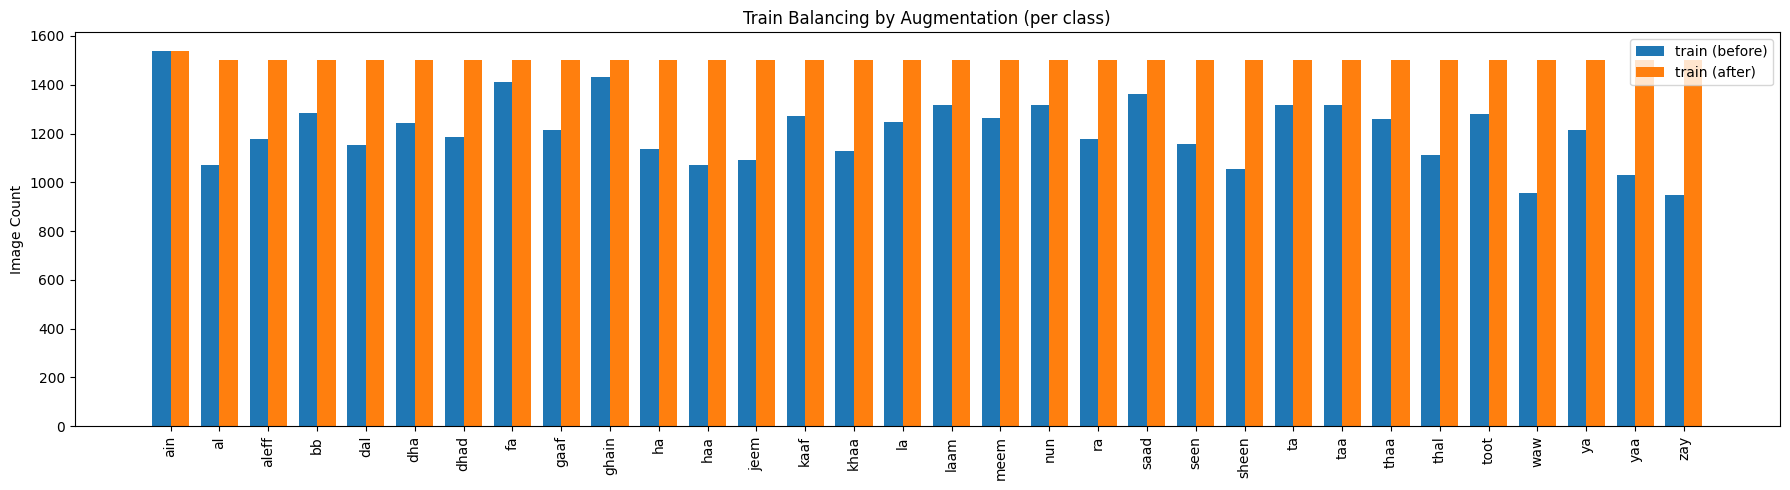

In [3]:
def safe_augment(img):
    # نفترض الصورة رمادية 64x64، لكن نتعامل عام لو كانت ملوّنة
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    out = img.copy()
    h, w = out.shape[:2]

    # 1) دوران بسيط
    angle = random.uniform(-5, 5)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    out = cv2.warpAffine(out, M, (w, h), borderValue=255)

    # 2) إزاحة بسيطة
    tx = random.randint(-2, 2)
    ty = random.randint(-2, 2)
    M2 = np.float32([[1, 0, tx], [0, 1, ty]])
    out = cv2.warpAffine(out, M2, (w, h), borderValue=255)

    # 3) سطوع/تباين بسيط
    alpha = random.uniform(0.9, 1.1)   # contrast
    beta  = random.randint(-10, 10)    # brightness
    out = cv2.convertScaleAbs(out, alpha=alpha, beta=beta)

    # 4) نويز خفيف
    noise = np.random.normal(0, 3, out.shape).astype(np.float32)
    out = np.clip(out.astype(np.float32) + noise, 0, 255).astype(np.uint8)
    return out

def resize_keep_64(out):
    # NOTE (Arabic): نضمن الحجم 64×64 لو حصل تغير بعد التحويلات
    return cv2.resize(out, (64, 64), interpolation=cv2.INTER_AREA)

# --- احصاء قبل التوازن ---
classes = sorted([d for d in TRAIN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "[ERROR] No classes found in train/"

def count_train():
    rows = []
    for c in classes:
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

df_before = count_train()
display(df_before.head(10))
print("[INFO] Train total (before):", int(df_before["count"].sum()))

# --- التوازن: نزيد الكلاسات الأقل حتى TARGET_PER_CLASS ---
for cls_dir in classes:
    imgs = [p for p in cls_dir.iterdir() if is_image(p)]
    cur  = len(imgs)
    if cur >= TARGET_PER_CLASS:
        continue

    # نستخدم فقط الصور الأصلية كمصدر (تجنّب تكدّس augment على augment)
    base_imgs = [p for p in imgs if "_aug_" not in p.stem]
    if not base_imgs:
        base_imgs = imgs  # احتياط

    idx = 0
    need = TARGET_PER_CLASS - cur
    with tqdm(total=need, desc=f"Augment {cls_dir.name}") as bar:
        while cur < TARGET_PER_CLASS and base_imgs:
            src = base_imgs[idx % len(base_imgs)]
            im  = cv2.imread(str(src), cv2.IMREAD_GRAYSCALE)
            if im is None:
                idx += 1
                continue
            aug = safe_augment(im)
            aug = resize_keep_64(aug)

            out_name = f"{src.stem}_aug_{cur}.png"
            out_path = cls_dir / out_name
            cv2.imwrite(str(out_path), aug)

            cur += 1
            idx += 1
            bar.update(1)

print("[INFO] Balancing finished to target:", TARGET_PER_CLASS)
# --- احصاء بعد التوازن + رسم للمقارنة داخل train فقط ---
df_after = count_train()
display(df_after.head(10))
print("[INFO] Train total (after):", int(df_after["count"].sum()))

# رسم مقارنة قبل/بعد (train فقط)
merged = df_before.merge(df_after, on="class", suffixes=("_before", "_after"))
x = np.arange(len(merged))
width = 0.38
plt.figure(figsize=(18,5))
plt.bar(x - width/2, merged["count_before"], width, label="train (before)")
plt.bar(x + width/2, merged["count_after"],  width, label="train (after)")
plt.xticks(x, merged["class"], rotation=90)
plt.ylabel("Image Count")
plt.title("Train Balancing by Augmentation (per class)")
plt.legend()
plt.tight_layout()
plt.show()